https://drive.google.com/open?id=0B-zGzdkbH440aDh1ckN4SWJlQ2ozeGM2cTNWN0lEY2R6NVhN

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor

In [16]:
from sklearn.model_selection import train_test_split, cross_validate, validation_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

In [17]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

expit  # sigmoid


from scipy import interp


def align_roc_curve(fpr, tpr, grid=100):
    """calculate ROC curve on a predefined grid by interpolating"""
    if isinstance(grid, int):
        fpr_aligned = np.linspace(0, 1, grid+1)
    else:
        fpr_aligned = grid    
    tpr_aligned = interp(fpr_aligned, fpr, tpr)
    tpr_aligned[0] = 0.
    return fpr_aligned, tpr_aligned

### Ia. ROC curve and AUC (practical)

.1. Sample $X_1 \in R^{m_1×n}$
elementwise from standard normal distribution, e.g. use <code>np.random.randn(m1, n)</code>;

.2. Sample true parameters' vector $w$ elementwise from normal distribution with
standard deviation 0.1, e.g. <code>w = 0.1 * np.random.randn(n);</code>

.3. For each object (both in training sample defined by $X_1$ and testing sample defined
by $X_2$) calculate the probability $p_j$ that object $x_j$ belongs to class 1 according to
logistic regression model, i.e. $p_j = \sigma(w^T x_j)$;

.4. Sample the class label for each object (both in training sample defined by $X_1$ and
testing sample defined by $X_2$) from Bernoulli distribution with corresponding
probability of first class, i.e. $y_j \propto Be(p_j)$.

In [18]:
m1 = 1000
m2 = 10000
n  = 20

In [19]:
# sample data
X1 = np.random.randn(m1, n)
X2 = np.random.randn(m2, n)
# sample true parameters of underlying model from N(0, 0.1^2)
w  = 0.1 * np.random.randn(n)
# generate labels for training and testing
p1 = sigmoid(np.dot(X1, w))
p2 = sigmoid(np.dot(X2, w))
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

.5. Split learning sample into 2 of size 800 and 200;

.6. Train linear SVM with a grid of regularization strength $C$ values on the first one of size 800, calculate ROC-curve and check AUC of its predictions for the second subsample of size 200;

.7. Repeat the split multiple times and plot the histogram of AUC distribution for the subsample of size 200 as well as the average ROC-curve;

In [20]:
ppe = ProcessPoolExecutor(max_workers=4)


fpr_aligned = np.linspace(0, 1, 101)


def run_cross_validation((experiment, Cs)):
    X_train, X_validate, y_train, y_validate = train_test_split(X1, y1, train_size=800, random_state=experiment+1000)
    data = []
    for C in Cs:
        rec = {
            "experiment": experiment,
            "C"         : C,
        }
        clf.set_params(C=C)
        clf.fit(X_train, y_train)
        rec["coef"] = clf.coef_.flatten()
        for (prefix, X, y) in [("val", X_validate, y_validate), ("train", X_train, y_train)]: 
            y_score = clf.decision_function(X)
            y_predicted = clf.predict(X)
            fpr, tpr, thresholds = roc_curve(y, y_score)
            _, tpr_aligned = align_roc_curve(fpr, tpr, grid=fpr_aligned)

            rec["%s_auc" % prefix]      = auc(fpr, tpr)
            rec["%s_tpr" % prefix]      = tpr_aligned
            rec["%s_accuracy" % prefix] = accuracy_score(y, y_predicted)
            rec["%s_npos" % prefix] = (y_predicted > 0).sum()
        data.append(rec)
    return data

def run_experiments(clf, Cs, nexperiments=100):
    data = []
    data = ppe.map(run_cross_validation, [(i, Cs) for i in range(nexperiments)])
    data = [rec for x in data for rec in x]
    df = pd.DataFrame(data)
    return df



In [21]:
def plot_experiments_stats(df, Cs):
    """For each C plot:
    * avg ROC with +-1std band
    * hist(AUC)
    * hist(ACC)
    includes both train and val sets
    """
    f = plt.figure(figsize=(18,len(Cs) * 2))
    axs = f.subplots(len(Cs), 3, sharex='col', )
    for i, C in enumerate(Cs):
        df_C = df[(df["C"] - C).abs() < 1e-12]
        ax = axs[i, 0]
        for prefix in ["val", "train"]:
            m_tpr = np.vstack(df_C["%s_tpr" % prefix])
            roc_mean = m_tpr.mean(0)
            roc_std  = m_tpr.std(0)
            roc_upper = np.minimum(roc_mean + roc_std, 1.)
            roc_lower = np.maximum(roc_mean - roc_std, 0.)
            ax.plot(fpr_aligned, roc_mean)
            ax.fill_between(fpr_aligned, roc_lower, roc_upper, alpha=0.3)
        ax.plot(fpr_aligned, fpr_aligned, label='clf_random', color='black')
        ax.set_title("Avg ROC. C=%.e" % C)
        ax = axs[i, 1]
        sns.distplot(df_C["val_auc"], rug=True, kde=True, ax=ax)
        ax.axvline(x= df_C["val_auc"].mean(), ls='--')
        sns.distplot(df_C["train_auc"], rug=True, kde=True, ax=ax)
        ax.axvline(x= df_C["train_auc"].mean(), ls='--')
        ax.set_title("Hist(AUC). C=%.e" % C)
        ax = axs[i, 2]
        sns.distplot(df_C["val_accuracy"], rug=True, kde=True, ax=ax, )
        ax.axvline(x= df_C["val_accuracy"].mean(), ls='--')
        sns.distplot(df_C["train_accuracy"], rug=True, kde=True, ax=ax, )
        ax.axvline(x= df_C["train_accuracy"].mean(), ls='--')
        ax.set_title("Hist(Accuracy). C=%.e" % C)

    for ax in axs.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)
        ax.autoscale()
        ax.legend(loc="upper left")
    f.tight_layout()

def plot_cv(df, Cs):
    """ plot devepndency of avg AUC, ACC and npositives from C (reg strength)
    """
    f = plt.figure(figsize=(18, 4))
    axs = f.subplots(1, 4, squeeze=False)

    def _plot(ax, field):
        means = np.array([df[df['C']==C][field].mean() for C in Cs])
        stds = np.array([df[df['C']==C][field].std() for C in Cs])
        xlabels = np.log10(Cs)
        ax.plot(xlabels, means, label=field)
        ax.fill_between(xlabels, means - stds, means + stds, alpha=0.3)

    _plot(axs[0, 0], "val_accuracy")
    _plot(axs[0, 0], "train_accuracy")
    axs[0,0].set_title("accuracy")
    _plot(axs[0, 1], "val_auc")
    _plot(axs[0, 1], "train_auc")
    axs[0,1].set_title("auc")
    _plot(axs[0, 2], "val_npos")
    _plot(axs[0, 2], "train_npos")
    axs[0,2].set_title("npos")
    ax = axs[0,3]
    ax.plot(np.log10(Cs), np.vstack(df.groupby('C')['coef'].apply(lambda x: np.vstack(x).mean(0)).values))
    axs[0,3].set_title("coef")
    for ax in axs.flatten():
        ax.legend(loc="upper center", fontsize="x-small")    

.8. Select regularization strength $C^∗$ that delivers maximum average (or median) AUC on the subsample of size 200;

I am using median below

.9. Check performance of SVM with selected $C = C^∗$ trained on the full learning sample on testing sample $(X_2, y_2)$ in terms of AUC and prediction accuracy. How far are these values from the AUC and prediction accuracy on learning sample? Do you think there is some systematic difference or is it explained just by noise?

__Answer__: The difference is explained by overfitting.
We can easily reject __H0: no difference between E[score_train-score_val] == 0__ based on our experiments above by computing t-stat. So this is a systematic effect.
Additionally, the values I got for score_learn on (X1, y1) vs score_test on (X2, y2) are within 1 std of expected difference.

__QUESTION__: argmax(AUC_val) gave me C=0.001 but after I trained it on full learn data set I got bad ACC even in sample! But if I override it to C=0.01 or larger, then ACC is improved while AUC stays roughly the same! While I can do sanity checks like checkcking that AUC and ACC in sample are not too far from their averages on a smaller set, what should be a reliable way of selecting C in practice?


|          |      AUC |      ACC
|----------|--------------------
|train      |0.656383  |0.533000
|test       |0.596575  |0.510600
|diff       |0.059808  |0.022400
|E[diff]    |0.043924  |0.034025
|std[diff]  |0.038505  |0.033013

>H0: E[diff_accuracy] == 0:  Ttest_1sampResult(statistic=10.306564830797658, pvalue=2.3475845529523207e-17)

>H0: E[diff_auc] == 0     :  Ttest_1sampResult(statistic=11.40735631591701, pvalue=9.6108153560957188e-20)

.10. Train logistic regression model (sklearn.linear_model.LogisticRegression) with a grid of regularization strength $\tau$ values including 0 (C in that python class) both
for quadratic and $l_1$ penalties (penalty parameter for this python class) on the first subsample of size 800, calculate ROC-curve and check AUC of its predictions
for the second subsample of size 200;
.11. Repeat the split multiple times and plot the histogram of AUC distribution for the subsample of size 200 as well as the average ROC-curve;
.12. Select regularization strength $\tau^*$ that delivers maximum average (or median) AUC on the subsample of size 200. What optimal regulatization strength do you get? Why?

__Answer__: 

* for l2 C=0.001, but there is almost no difference between different Cs.
* for l1 C = 0.1, I was getting even better median val_AUC for 0.001 and 0.01, but when I was using this C to fit clf on full learning set, I was getting all zero coefficients, so I had to select greater C
  * __But I still have several zeros in the final classifier. Is it OK or should I improve my selection procedure for C?__



.13. Check performance of logistic regression with selected $\tau = \tau^*$ trained on the full learning sample on testing sample $(X_2, y_2)$ in terms of AUC and prediction
accuracy. How far are these values from the AUC and prediction accuracy on learning sample? Do you think there is some systematic dierence or is it explained just by noise?

__Answer__: Same answer as for 9

For L2:

|          |      AUC |      ACC
|----------|--------------------
|train     | 0.657098 | 0.616000
|test      | 0.598545 | 0.571000
|diff      | 0.058554 | 0.045000
|E[diff]   | 0.043924 | 0.034025
|std[diff] | 0.038505 | 0.033013

>H0: E[diff_accuracy] == 0:  Ttest_1sampResult(statistic=10.306564830797658, pvalue=2.3475845529523207e-17)

>H0: E[diff_auc] == 0     :  Ttest_1sampResult(statistic=11.40735631591701, pvalue=9.6108153560957188e-20)


For L1:

|         |      AUC|       ACC
|--------------------------------
|train      |0.655592 | 0.624000
|test       |0.595639 | 0.568200
|diff       |0.059945 | 0.055800
|E[diff]    |0.045738 | 0.035825
|std[diff]  |0.039111 | 0.033706

>H0: E[diff_accuracy] == 0:  Ttest_1sampResult(statistic=10.628560969124628, pvalue=4.6744109730264517e-18)

>H0: E[diff_auc] == 0     :  Ttest_1sampResult(statistic=11.694385996615903, pvalue=2.3174749377246485e-20)


svm
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[  1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02]
running experiments
CPU times: user 41.7 ms, sys: 8.62 ms, total: 50.3 ms
Wall time: 806 ms
plotting stats
choosing C*
C
0.0001      0.617291
0.0010      0.618143
0.0100      0.617540
0.1000      0.616790
1.0000      0.616472
10.0000     0.616522
100.0000    0.616522
Name: val_auc, dtype: float64
C* = 0.001

COEFFICIENTS vs real WEIGHTS
    abs_coef      coef    weight
2   0.001039 -0.001039  0.051229
16  0.001562  0.001562  0.092054
3   0.003856  0.003856  0.081457
1   0.004533  0.004533 -0.060113
7   0.005039 -0.005039 -0.129920
17  0.007641 -0.007641 -0.043727
15  0.007790 -0.007790 -0.016267
10  0.014119  0.014119  0.045650
11  0.0144

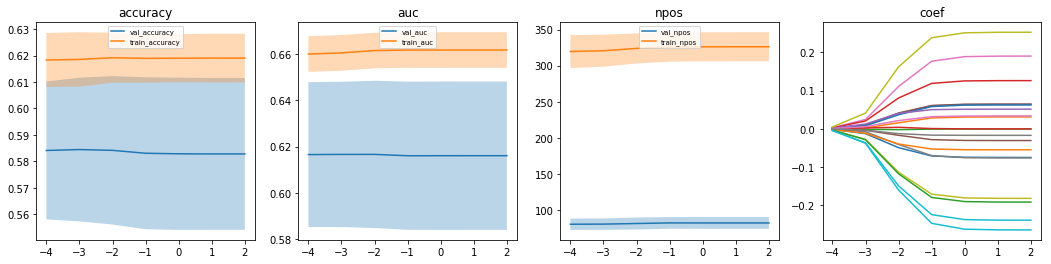

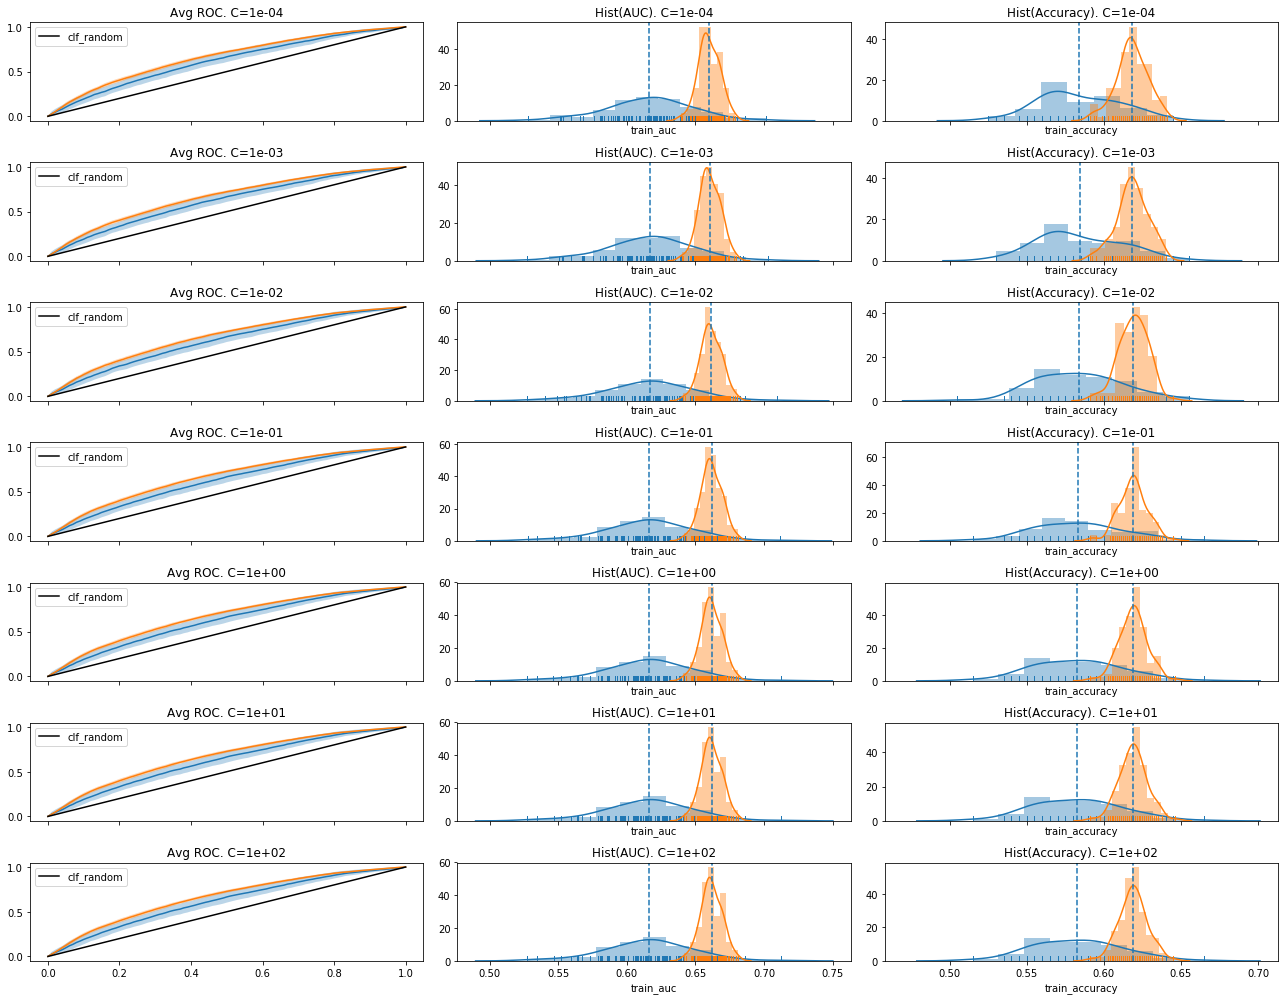

In [49]:
### CHANGE CLASSIFIER HERE ###

CHECK="svm"

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression



if CHECK == "svm":
    clf = SVC(kernel='linear', max_iter=-1 )
    Cs = np.logspace(-4, 2, 7)
elif CHECK == "logit_l2":
    clf = LogisticRegression(C=1, penalty="l2")
    Cs = np.logspace(-6, 4, 11)
elif CHECK == "logit_l1":
    clf = LogisticRegression(C=1, penalty="l1")
    Cs = np.logspace(-6, 4, 11)
else:
    raise ValueError, "unsupported clf"

print CHECK
print clf
print Cs

########################################

print "running experiments"
%time df = run_experiments(clf, Cs, nexperiments=100)


print "plotting stats"  
plot_cv(df, Cs)
plot_experiments_stats(df, Cs)

print "choosing C*"
print df.groupby('C')["val_auc"].median()

C_min = 1e-10
while 1:
    candidates = df.groupby('C')["val_auc"].median()
    candidates = candidates[candidates.index > C_min]
    if candidates.empty:
        raise RuntimeError, "cannot choose C_"
    C_ = candidates.argmax()
    print "C* =", C_
    clf.set_params(C=C_)
    clf.fit(X1, y1)
    if np.abs(clf.coef_).sum() == 0:
        print "all coeffs are zeros, need to override"
        C_min = C_
    else:
        break

### OVERRIDE FOR SVM (to enable, change False -> True)
if False and CHECK == "SVM":
    C_=1.
    clf.set_params(C=C_)
    clf.fit(X1, y1)

print 
print "COEFFICIENTS vs real WEIGHTS"
print pd.DataFrame({"weight": w, "coef": clf.coef_.flatten(), "abs_coef": np.abs(clf.coef_.flatten())}).sort_values("abs_coef")
#print clf.coef_

# override, because something seems wrong with too low values of C    

y1_predicted = clf.predict(X1)
y1_score = clf.decision_function(X1)
train_auc = roc_auc_score(y1, y1_score)
train_accuracy = accuracy_score(y1, y1_predicted)

res = pd.DataFrame()
res.loc["train", "AUC"] = train_auc
res.loc["train", "ACC"] = train_accuracy

y2_predicted = clf.predict(X2)
y2_score = clf.decision_function(X2)
test_auc = roc_auc_score(y2, y2_score)
test_accuracy = accuracy_score(y2, y2_predicted)
res.loc["test", "AUC"] = test_auc
res.loc["test", "ACC"] = test_accuracy
res.loc["diff"] = res.loc["train"] - res.loc["test"]

_df = df[(df["C"] - C_).abs() < 1e-10]
_df.loc[:, "diff_accuracy"] = _df["train_accuracy"] - df["val_accuracy"]
_df.loc[:, "diff_auc"] = _df["train_auc"] - df["val_auc"]

res.loc["E[diff]", "AUC"] = (_df["diff_auc"]).mean()
res.loc["E[diff]", "ACC"] = (_df["diff_accuracy"]).mean()
res.loc["std[diff]", "AUC"] = (_df["diff_auc"]).std()
res.loc["std[diff]", "ACC"] = (_df["diff_accuracy"]).std()

print
print res
print

import scipy.stats
print "H0: E[diff_accuracy] == 0: ", scipy.stats.ttest_1samp(_df["diff_accuracy"], 0)
print "H0: E[diff_auc] == 0     : ", scipy.stats.ttest_1samp(_df["diff_auc"], 0)

# 1b. ROC curve and AUC (semi-practical)

For the settings above
.1. Sample random vector $w_0 \in R^n$ elementwise from normal distribution with standard deviation 0.1, e.g. <code>w0 = 0.1 np.random.randn(n)</code> independently from $w$. Let $w_0$ be noise estimate of true vector $w$;

.2. Calculate AUC on testing sample $(X_2, y_2)$ for logistic regression model with parameters' vector $w_0$ and plot corresponding ROC-curve;

.3. Repeat the previous two steps (apart from saving ROC-curves for all repetitions) multiple times. What is the average AUC you are getting?

__Answer__: 

avg(AUC) = 0.5012

std(AUC) = 0.0294

.4. Calculate E(AUC) in such experiment.

__Answer__: 0.5

TODO: write down the derivation

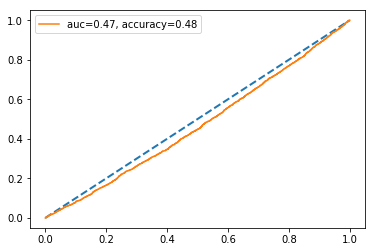

In [51]:
w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
prob_predicted = sigmoid(np.dot(X2, w0))
y_predicted = prob_predicted > 0.5
fpr, tpr, thresholds = roc_curve(y2, prob_predicted)

f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(1,1,1)
ax.plot([0,1], lw=2, ls='--')
accuracy = accuracy_score(y2, y_predicted)
ax.plot(fpr, tpr, label="auc=%.2f, accuracy=%.2f" % (auc(fpr, tpr), accuracy))
ax.legend()


0.5012 +/- 0.0294


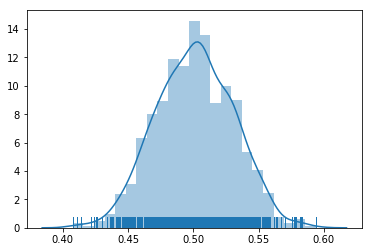

In [63]:
l_auc = []
for _ in range(1000):
    w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
    prob_predicted = sigmoid(np.dot(X2, w0))
    l_auc.append(roc_auc_score(y2, prob_predicted))

sns.distplot(l_auc, rug=True)
print "%.4f +/- %.4f" % (np.mean(l_auc), np.std(l_auc))

(array([3., 2., 1., 2., 2., 2., 2., 2., 2., 2.]),
 array([0.03922077, 0.04141014, 0.0435995 , 0.04578886, 0.04797823,
        0.05016759, 0.05235695, 0.05454632, 0.05673568, 0.05892504,
        0.0611144 ]),
 <a list of 10 Patch objects>)

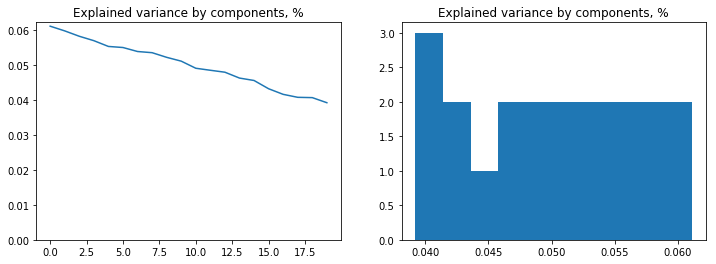

In [123]:
pca = PCA()
pca.fit(X1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1, 2, 1, title="Explained variance by components, %")
ax.plot(pca.explained_variance_ratio_)
ax.set_ylim(bottom=0)
ax = f.add_subplot(1, 2, 2, title="Explained variance by components, %")
ax.hist(pca.explained_variance_ratio_)
#sns.kdeplot(pca.explained_variance_ratio_, ax=ax, kernel='cos')



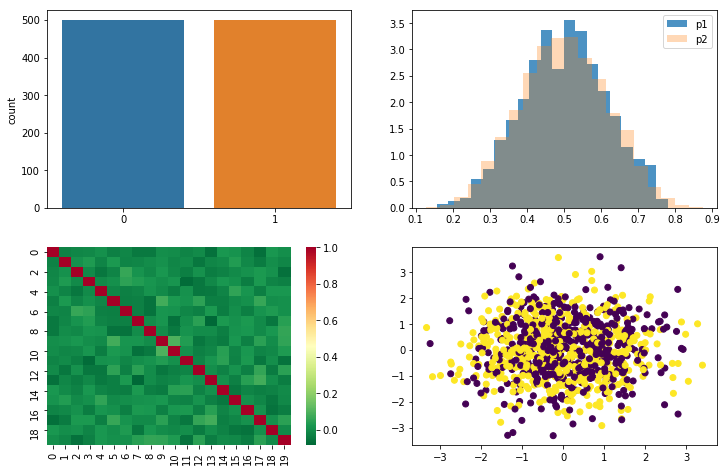

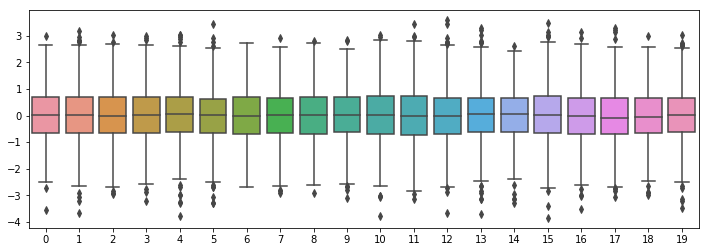

In [9]:
f = plt.figure(figsize=(12,8))
axs = f.subplots(2, 2)
sns.countplot(y1, ax=axs[0, 0])
#ax.hist()
#sns.kdeplot()
axs[0, 1].hist(p1, alpha=0.8, bins=20, label="p1", density=True)
axs[0, 1].hist(p2, alpha=0.3, bins=20, label="p2", density=True)
axs[0, 1].legend()
sns.heatmap(np.corrcoef(X1.T), cmap='RdYlGn_r', ax=axs[1,0])
_X = pca.transform(X1)[:, :2]
axs[1, 1].scatter(_X[:, 0], _X[:, 1], c=y1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1,1,1)
sns.boxplot(data=X1, )
#_ = ax.boxplot(X1)


In [157]:
clf.set_params(C=1e-5)

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [158]:
X_train, X_validate, y_train, y_validate_true = train_test_split(X1, y1, train_size=0.8)
clf.fit(X_train, y_train)
y_validate_score = clf.decision_function(X_validate)
y_validate_predicted = clf.predict(X_validate)


{'boxes': [<matplotlib.lines.Line2D at 0x186e8400>],
 'caps': [<matplotlib.lines.Line2D at 0x1d5e5550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d5e5940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d5e52b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x186e8390>,
  <matplotlib.lines.Line2D at 0x1d5e5a90>]}

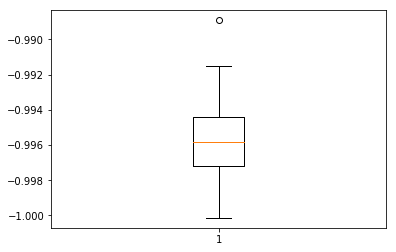

In [159]:
plt.boxplot(y_validate_score)

In [165]:
from scipy.stats import itemfreq
print Counter(y_validate_score > 0)
print itemfreq(y_validate_true)

print roc_auc_score(y_validate_true, y_validate_score)
print accuracy_score(y_validate_true, y_pred=y_validate_predicted)

Counter({False: 200})
[[  0  91]
 [  1 109]]
0.6051013206976509
0.455


In [168]:
109 / 200.

0.545

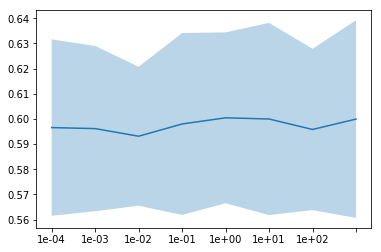

In [44]:
df_auc = pd.DataFrame(data, columns=['C', 'auc.mean', 'auc.std'])
f, ax = plt.subplots()
ax.plot(df_auc["auc.mean"])
ax.fill_between(np.arange(len(df_auc)), 
                 df_auc["auc.mean"] - df_auc["auc.std"], 
                 df_auc["auc.mean"] + df_auc["auc.std"],
                 alpha = 0.3,
                )
_ = ax.set_xticklabels(["%.e" % x for x in df_auc["C"]])

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', lw=lw)


In [59]:
clf = LogisticRegression( C=1.)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)